### Computer vision libaries in PyTorch 
* `torchvision` - base domain library for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [3]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)
     

2.2.1+cpu
0.17.1+cpu


In [4]:
train_data = datasets.FashionMNIST(
    root="data",  # where to download data to? 
    train=True, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None 
)

test_data = datasets.FashionMNIST(
    root="data",  
    train=False, 
    download=True, 
    transform=ToTensor(), 
    target_transform=None 
)

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes 
class_names 

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx 
class_to_idx 

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
image, label = train_data[0] 
print(image.shape, label)

torch.Size([1, 28, 28]) 9


Label:  Ankle boot


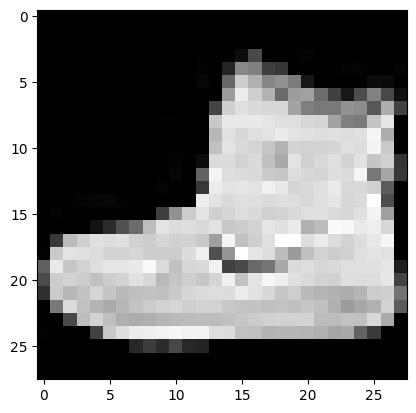

In [10]:
plt.imshow(image.squeeze(), cmap="gray");  # matpotlib expects channels to be last(HWC) or HW 
print("Label: ", class_names[label]) 

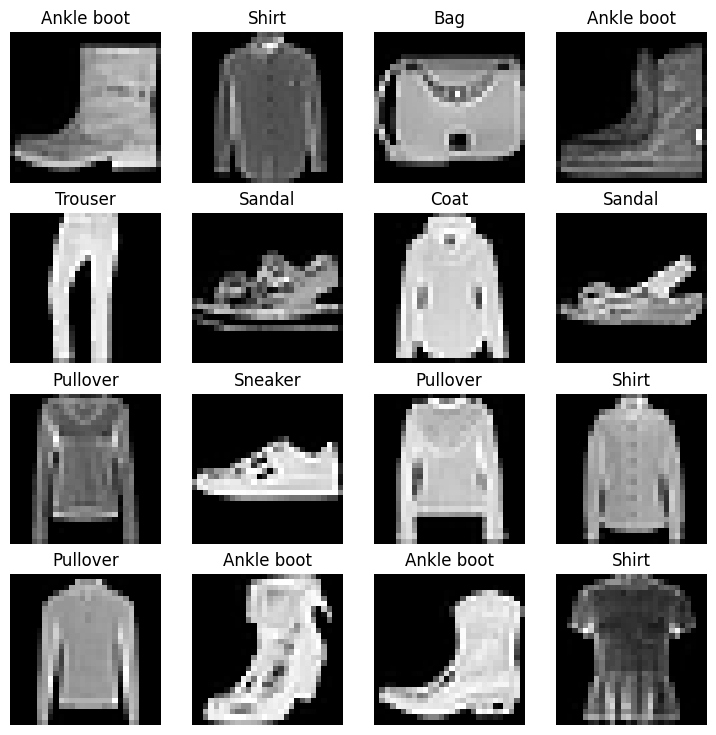

In [11]:
torch.manual_seed(42) 
fig = plt.figure(figsize=(9, 9)) 
rows, cols = 4, 4 

for i in range(1, rows*cols+1): 
    random_idx = torch.randint(len(train_data), size=[1]).item() 
    img, label = train_data[random_idx] 
    fig.add_subplot(rows, cols, i) 
    plt.imshow(img.squeeze(), cmap="gray") 
    plt.title(class_names[label]) 
    plt.axis(False) 

In [12]:
from torch.utils.data import DataLoader 

BATCH_SIZE = 32 

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True) 
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False) 

In [13]:
len(train_loader), len(test_loader)   # 60000 // 32 = 1875, 10000 // 32 = 312 

(1875, 313)

In [14]:
train_features_batch, train_labels_batch = next(iter(train_loader)) 
train_features_batch.shape, train_labels_batch.shape 

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [15]:
train_labels_batch

tensor([5, 1, 8, 1, 5, 2, 6, 7, 3, 5, 9, 5, 7, 5, 0, 4, 4, 4, 4, 6, 1, 8, 0, 1,
        9, 7, 8, 8, 3, 3, 7, 2])

In [16]:
flatten_model = nn.Flatten() 

x = train_features_batch[0] 

output = flatten_model(x) 

print("x.shape: ", x.shape)
print("output.shape: ", output.shape)

x.shape:  torch.Size([1, 28, 28])
output.shape:  torch.Size([1, 784])


In [17]:
from torch import nn 

class FashionMNISTModelV0(nn.Module): 
    def __init__(self, input_shape, hidden_units, output_shape): 
        super().__init__() 
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x): 
        return self.layer_stack(x)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(42) 

model_0 = FashionMNISTModelV0(input_shape=28*28, hidden_units=128, output_shape=10).to(device) 
model_0 

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [19]:
dummy_batch_x = torch.rand(32, 1, 28, 28).to(device) 
print(model_0(dummy_batch_x).shape) 

dummy_x = torch.rand(1, 1, 28, 28).to(device) 
model_0(dummy_x)

torch.Size([32, 10])


tensor([[-0.0707, -0.0736, -0.3887, -0.0480, -0.0935,  0.0007, -0.0110, -0.0704,
          0.2149,  0.2556]], grad_fn=<AddmmBackward0>)

In [20]:
from helper_functions import accuracy_fn

In [21]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01) 

In [22]:
torch.manual_seed(42) 

epochs = 3 

for epoch in range(epochs): 
    print(f"Epoch: {epoch}\n-------------------") 
    train_loss = 0 
    
    for batch, (X, y) in enumerate(train_loader): 
        model_0.train() 
        
        X, y = X.to(device), y.to(device) 
        
        y_pred = model_0(X) 
        
        loss = loss_fn(y_pred, y) 
        train_loss += loss  # total loss 누적 -> epoch 단위로 모든 batch의 평균 loss를 구하기 위함 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()  # batch 단위로 parameter update 
        
        if batch % 400 == 0: 
            print(f"Looked at {batch * len(X)} / {len(train_loader.dataset)} samples.") 
    
    train_loss /= len(train_loader)
    
    ### testing 
    test_loss, test_acc = 0, 0 
    model_0.eval() 
    
    with torch.inference_mode(): 
        for X_test, y_test in test_loader: 
            X_test, y_test = X_test.to(device), y_test.to(device) 
            
            y_pred = model_0(X_test) 
            
            test_loss += loss_fn(y_pred, y_test) 

            test_acc += accuracy_fn(y_test, y_pred.argmax(dim=1))  # y_pred: NC -> N 
        
        test_loss /= len(test_loader)
        test_acc /= len(test_loader) 
        
    # print out what happening 
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")

Epoch: 0
-------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.7412, Test Loss: 0.5673, Test Acc: 82.0587

Epoch: 1
-------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.7207, Test Loss: 0.6442, Test Acc: 79.8423

Epoch: 2
-------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.6962, Test Loss: 0.7864, Test Acc: 79.3730



In [23]:
from tqdm.auto import tqdm

torch.manual_seed(42) 

def eval_model(model, data_loader, loss_fn, accuracy_fn):
    """returns a dictionary containing the results of model predictiong on data_loader.""" 
    loss, acc = 0, 0 
    model.eval() 
    with torch.inference_mode(): 
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device) 
            
            y_pred = model(X) 
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1)) 
            
        # scale loss and acc to find the average loss / acc per batch 
        loss /= len(data_loader) 
        acc /= len(data_loader) 
    
    return {"model_name": model.__class__.__name__, "loss": loss.item(), "acc": acc} 

c:\Users\jusung\Desktop\2024\ZTM_PyTorch\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
model_0_results = eval_model(model_0, test_loader, loss_fn, accuracy_fn)
model_0_results 

100%|██████████| 313/313 [00:01<00:00, 305.07it/s]


{'model_name': 'FashionMNISTModelV0',
 'loss': 0.7864258289337158,
 'acc': 79.37300319488818}

### Building a better model with non-linearity

In [25]:
from torch import nn 

class FashionMNISTModelV1(nn.Module): 
    def __init__(self, input_shape, hidden_units, output_shape): 
        super().__init__() 
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x): 
        return self.layer_stack(x)

In [26]:
model_1 = FashionMNISTModelV1(input_shape=28*28, hidden_units=128, output_shape=10).to(device) 
model_1 

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [27]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01) 

In [28]:
epochs = 3 

for epoch in range(epochs): 
    print(f"Epoch: {epoch}\n------------------------")
    model_1.train() 
    train_loss = 0 
    
    for batch, (X, y) in enumerate(train_loader): 
        X, y = X.to(device), y.to(device)  # X: NCWH, y: N 
        
        # forward padd 
        logits = model_1(X)  # NCWH -> NC 
        pred_probs = torch.softmax(logits, dim=1) 
        pred_labels = pred_probs.argmax(dim=1)  # NC -> C 
        
        loss = loss_fn(logits, y)   
        train_loss += loss 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
        if batch % 400 == 0: 
            print(f"Looked at {batch * len(X)} / {len(train_loader.dataset)} samples.")
            
    train_loss /= len(train_loader) 
    
    model_1.eval() 
    with torch.inference_mode(): 
        test_loss, test_acc = 0, 0 
        for test_X, test_y in test_loader: 
            test_X, test_y = test_X.to(device), test_y.to(device) 
            
            test_logits = model_1(test_X) 
            test_preds = test_logits.argmax(dim=1) 
            
            test_loss += loss_fn(test_logits, test_y) 
            test_acc += accuracy_fn(test_y, test_preds)
        
        test_loss /= len(test_loader) 
        test_acc /= len(test_loader) 
        
    
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}\n")

Epoch: 0
------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.5257, Test Loss: 0.5217, Test Acc: 81.7692

Epoch: 1
------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.4326, Test Loss: 0.5181, Test Acc: 83.1669

Epoch: 2
------------------------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.
Train Loss: 0.4147, Test Loss: 0.4842, Test Acc: 83.3566



In [29]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device): 
    """Performs a training with model trying to learn on data_laoder.""" 
    
    model.train()
    train_loss, train_acc = 0, 0 
    
    for batch, (X, y) in enumerate(data_loader): 
        X, y = X.to(device), y.to(device) 
        
        y_pred = model(X) 
        
        loss = loss_fn(y_pred, y) 
        train_loss += loss 
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1)) 
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        
    train_loss /= len(data_loader) 
    train_acc /= len(data_loader) 
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [30]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device): 
    """Performs a testing loop step on model going over data_loader.""" 
    
    model.eval() 
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode(): 
        for X, y in data_loader: 
            X, y = X.to(device), y.to(device) 
            
            # forward pass 
            test_pred = model(X) 
            
            # calculate the loss / acc 
            test_loss += loss_fn(test_pred, y) 
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1)) 
            
        test_loss /= len(data_loader) 
        test_acc /= len(data_loader) 
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%") 

In [31]:
torch.manual_seed(42) 

model_1 = FashionMNISTModelV1(input_shape=28*28, hidden_units=128, output_shape=10).to(device) 

loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01) 

epochs = 3 

for epoch in range(epochs): 
    print(f"\nEpoch: {epoch}\n--------------------") 
    
    train_step(model_1, train_loader, loss_fn, optimizer, accuracy_fn, device) 
    
    test_step(model_1, test_loader, loss_fn, accuracy_fn, device)
    


Epoch: 0
--------------------
Train loss: 0.52008 | Train acc: 81.33%
Test loss: 0.53486 | Test acc: 81.06%

Epoch: 1
--------------------
Train loss: 0.42925 | Train acc: 84.77%
Test loss: 0.44944 | Test acc: 84.23%

Epoch: 2
--------------------
Train loss: 0.41091 | Train acc: 85.38%
Test loss: 0.49082 | Test acc: 82.53%


In [32]:
model_1_results = eval_model(model=model_1, data_loader=test_loader, loss_fn=loss_fn, accuracy_fn=accuracy_fn) 
model_1_results 

100%|██████████| 313/313 [00:01<00:00, 296.12it/s]


{'model_name': 'FashionMNISTModelV1',
 'loss': 0.4908217787742615,
 'acc': 82.52795527156549}

In [33]:
model_0_results 

{'model_name': 'FashionMNISTModelV0',
 'loss': 0.7864258289337158,
 'acc': 79.37300319488818}

In [34]:
import torch 
from torch import nn 

# create a convolustional neural network 
# https://poloclub.github.io/cnn-explainer/
class FashionMNISTModelv2(nn.Module): 
    def __init__(self, input_shape, hidden_units, output_shape): 
        super().__init__() 
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d( in_channels=input_shape, 
                out_channels=hidden_units, 
                kernel_size=3, 
                stride=1, 
                padding=1 ), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            # nn.Linear(in_features=hidden_units*0,  trick 
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape) 
        )
        
    def forward(self, x): 
        x = self.conv_block_1(x) 
        # print(x.shape)
        x = self.conv_block_2(x) 
        # print(x.shape)
        return self.classifier(x) 
            
torch.manual_seed(42) 
model_2 = FashionMNISTModelv2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device) 
model_2 

FashionMNISTModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
class_num = 10 

model =FashionMNISTModelv2(input_shape=1, hidden_units=10, output_shape=class_num).to(device)

In [36]:
images = torch.randn((32, 3, 64, 64)) 
test_image = images[0] 

print(images.shape) 
print(test_image.shape) 

torch.Size([32, 3, 64, 64])
torch.Size([3, 64, 64])


In [37]:
torch.manual_seed(42) 

conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10, 
                       kernel_size=3, 
                       stride=1, 
                       padding=0) 

conv_output = conv_layer(test_image.unsqueeze(dim=0))
conv_output.shape 

torch.Size([1, 10, 62, 62])

In [38]:
conv_weight = conv_layer.state_dict()['weight'] 
conv_bias = conv_layer.state_dict()['bias'] 

# (out_dim, in_dim, w, h)
print(conv_weight.shape) 
# out_dim
print(conv_bias.shape) 

torch.Size([10, 3, 3, 3])
torch.Size([10])


In [39]:
max_pool_layer = nn.MaxPool2d(kernel_size=2) 

test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0)) 

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)

print(test_image_through_conv.shape)
test_image_through_conv_and_max_pool.shape 

torch.Size([1, 10, 62, 62])


torch.Size([1, 10, 31, 31])

In [40]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001) 

In [41]:

# Train and test model 
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.54253 | Train acc: 80.31%


 33%|███▎      | 1/3 [00:25<00:50, 25.28s/it]

Test loss: 0.41739 | Test acc: 84.74%
Epoch: 1
---------
Train loss: 0.35336 | Train acc: 87.06%


 67%|██████▋   | 2/3 [00:50<00:25, 25.21s/it]

Test loss: 0.36436 | Test acc: 86.95%
Epoch: 2
---------
Train loss: 0.31660 | Train acc: 88.45%


100%|██████████| 3/3 [01:16<00:00, 25.41s/it]

Test loss: 0.35536 | Test acc: 87.17%


In [42]:
model_2_results = eval_model(model_2, test_loader, loss_fn, accuracy_fn) 
model_2_results 

100%|██████████| 313/313 [00:01<00:00, 166.67it/s]


{'model_name': 'FashionMNISTModelv2',
 'loss': 0.3553624153137207,
 'acc': 87.17052715654953}

In [43]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,loss,acc
0,FashionMNISTModelV0,0.786426,79.373003
1,FashionMNISTModelV1,0.490822,82.527955
2,FashionMNISTModelv2,0.355362,87.170527


In [44]:
from torchsummary import summary 

summary(model_0, input_size=(1, 1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [45]:
summary(model_1, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [46]:
summary(model_2, input_size=(1, 28, 28)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                   [-1, 10]           4,910
Total params: 7,740
Trainable params: 7,740
Non-trainable params: 0
-----------------------------------

In [47]:
def make_predictions(model, data, device): 
    pred_probs = [] 
    
    model.eval() 
    with torch.inference_mode(): 
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) 
            
            pred_logit = model(sample)  # NC 
            
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=-1)  # NC -> C -> C  softmax는 차원을 유지 
            
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)  # NC

In [48]:
import random 

random.seed(42) 
test_samples = [] 
test_labels = [] 

for sample, label in random.sample(list(test_data), k=9): 
    test_samples.append(sample) 
    test_labels.append(label) 
    
print(len(test_samples), test_samples[0].shape) 
print(len(test_labels), test_labels[0])

9 torch.Size([1, 28, 28])
9 5


In [49]:
pred_probs = make_predictions(model=model_2, data=test_samples, device=device) 

print(pred_probs.shape) 
pred_probs[:2]

torch.Size([9, 10])


tensor([[7.5997e-10, 9.7985e-11, 1.6799e-09, 3.8594e-10, 1.4019e-12, 9.9981e-01,
         3.1702e-09, 8.8812e-07, 2.1595e-06, 1.8792e-04],
        [1.2683e-02, 8.7064e-01, 2.8112e-04, 9.0078e-02, 1.4012e-03, 6.1515e-07,
         2.4811e-02, 4.1048e-05, 6.6537e-05, 4.4594e-07]])

In [50]:
pred_classes = pred_probs.argmax(dim=-1) 
pred_classes 

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [51]:
test_labels, pred_classes 

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

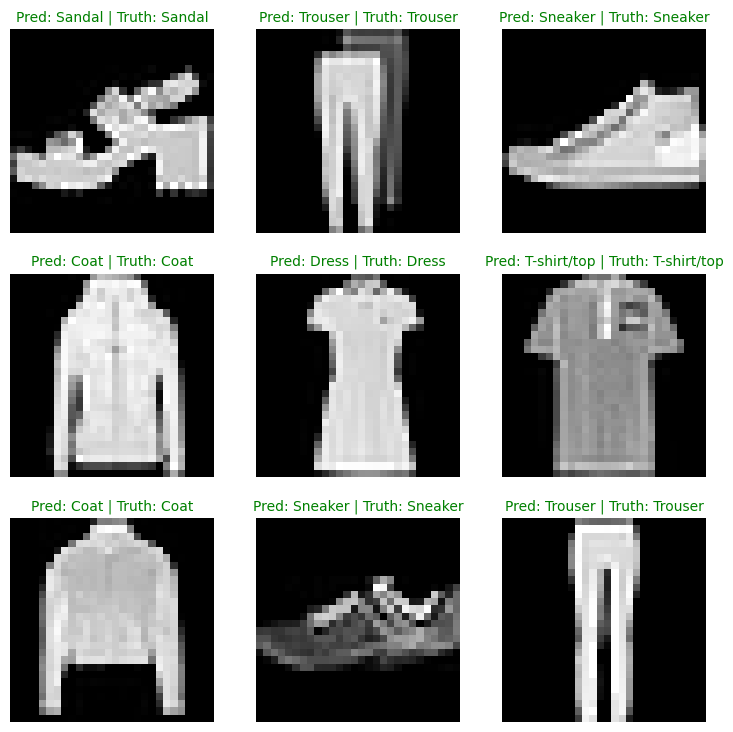

In [53]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(9, 9)) 
nrows = 3 
ncols = 3 

for i, sample in enumerate(test_samples): 
    plt.subplot(nrows, ncols, i+1) 
    plt.imshow(sample.squeeze(), cmap='gray') 
    
    pred_label = class_names[pred_classes[i]] 
    truth_label = class_names[test_labels[i]] 
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}" 
    
    if pred_label == truth_label: 
        plt.title(title_text, fontsize=10, c="g") 
    else: 
        plt.title(title_text, fontsize=10, c="r") 
    
    plt.axis(False) 
    

In [55]:
import mlxtend
mlxtend.__version__ 

'0.23.1'

In [70]:
from tqdm.auto import tqdm 

y_preds = [] 

model_2.eval() 
with torch.inference_mode(): 
    for X, y in tqdm(test_loader, desc="Making predictions"): 
        X, y = X.to(device), y.to(device) 
        y_logit = model_2(X) 
        y_pred = torch.softmax(y_logit, dim=-1).argmax(dim=-1) 
        y_preds.append(y_pred.cpu()) 
        
y_pred_tensor = torch.cat(y_preds, dim=0) # LNC -> NC  행으로 이어붙이기  

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 181.97it/s]


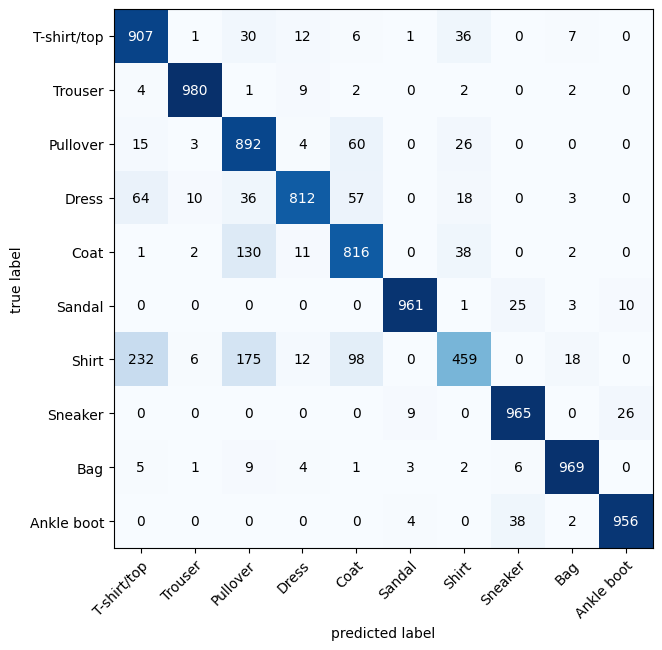

In [71]:
from torchmetrics import ConfusionMatrix 
from mlxtend.plotting import plot_confusion_matrix 

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets) 

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names, 
    figsize=(10, 7) 
)